## Applying mGPLVM to synthetic neural data generated from circular latents
_Calvin Kao & Kris Jensen (16 March 2022)_

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim

import mgplvm as mgp

torch.manual_seed(1)
np.random.seed(0)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

loading


### Generate synthetic data

Here, we generate synthetic neural data from the following generative model:

$$
\begin{align} 
\theta_{t} &\sim U(0, 2\pi)\\
f_{it} &\sim \mathcal{GP}(0, K(\theta, \theta'))\\
y_{it}  &\sim \mathcal{N}(f_{it}, \sigma_i^2 I)
\end{align}
$$

In [2]:
d = 1  # dimensions of latent space, here we just have a ring i.e. T(1)
n = 50  # number of neurons
m = 100  # number of conditions / time points
n_z = 50  # number of inducing points
n_samples = 1  # number of samples

In [3]:
gen = mgp.syndata.Gen(
    mgp.syndata.Torus(d), n, m, variability=0.1, l=0.5, n_samples=n_samples, sigma=0.1
)
Y = gen.gen_data()
print(f"Dimension of neural data Y: {Y.shape}")

Dimension of neural data Y: (1, 50, 100)


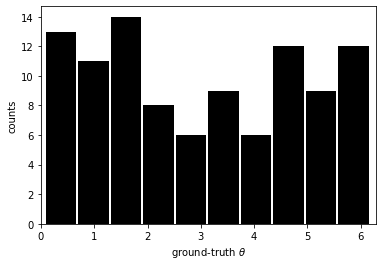

In [4]:
plt.figure()
plt.hist(gen.gs[0][0, :, 0], color="k", rwidth=0.95)
plt.xlim(0, 2 * np.pi)
plt.ylabel("counts")
plt.xlabel("ground-truth $\\theta$")
plt.show()

Raw data


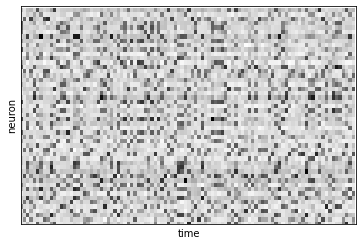

In [5]:
print(f"Raw data")
plt.figure()
Yplot = Y[0, :, :]
plt.imshow(Yplot, cmap="Greys", aspect="auto")
plt.xlabel("time")
plt.ylabel("neuron")
plt.xlim(0, m)
plt.ylim(0, n)
plt.xticks([])
plt.yticks([])
plt.show()

Let's now construct the mGPLVM model!

In [6]:
def build_model():
    # specify manifold, kernel and rdist
    manif = mgp.manifolds.Torus(m, d)  # latent distribution manifold
    lat_dist = mgp.rdist.ReLie(manif, m, n_samples)  # construct ReLie distribution
    # Note: we construct the kernel and likelihood by passing the data in for initialization
    kernel = mgp.kernels.QuadExp(
        n, manif.distance
    )  # Use an exponential quadratic (RBF) kernel
    lik = mgp.likelihoods.Gaussian(n)  # Gaussian likelihood
    lprior = mgp.lpriors.Uniform(manif)  # Prior on the manifold distribution
    z = manif.inducing_points(n, n_z)  # build inducing points
    model = mgp.models.SvgpLvm(
        n, m, n_samples, z, kernel, lik, lat_dist, lprior, whiten=True
    ).to(device)
    return model

In [7]:
data = torch.tensor(Y, device=device, dtype=torch.get_default_dtype())
model = build_model()

train_opts = {
    "lrate": 5e-2,
    "max_steps": 1000,
    "n_mc": 64,
    "print_every": 100,
    "burnin": 30 / 5e-2,
    "optimizer": optim.Adam,
}

# train model
progress = mgp.optimisers.svgp.fit(data, model, **train_opts)

iter   0 | elbo -5.604 | kl  0.002 | loss  5.604 | |mu| 0.110 | sig 1.500 | scale 1.000 | ell 2.000 | lik_sig 1.000 |
iter 100 | elbo -1.012 | kl  0.003 | loss  1.013 | |mu| 0.655 | sig 1.342 | scale 0.993 | ell 2.024 | lik_sig 0.948 |
iter 200 | elbo -0.686 | kl  0.008 | loss  0.688 | |mu| 0.751 | sig 1.014 | scale 0.984 | ell 2.073 | lik_sig 0.645 |
iter 300 | elbo -0.136 | kl  0.026 | loss  0.146 | |mu| 1.366 | sig 0.397 | scale 0.963 | ell 2.197 | lik_sig 0.272 |
iter 400 | elbo  0.343 | kl  0.052 | loss -0.318 | |mu| 1.711 | sig 0.108 | scale 0.912 | ell 1.823 | lik_sig 0.153 |
iter 500 | elbo  0.528 | kl  0.066 | loss -0.490 | |mu| 1.746 | sig 0.054 | scale 0.875 | ell 1.471 | lik_sig 0.129 |
iter 600 | elbo  0.568 | kl  0.074 | loss -0.522 | |mu| 1.749 | sig 0.038 | scale 0.846 | ell 1.296 | lik_sig 0.124 |
iter 700 | elbo  0.564 | kl  0.078 | loss -0.511 | |mu| 1.742 | sig 0.031 | scale 0.807 | ell 1.224 | lik_sig 0.128 |
iter 800 | elbo  0.612 | kl  0.080 | loss -0.552 | |mu| 

Text(0, 0.5, 'training loss')

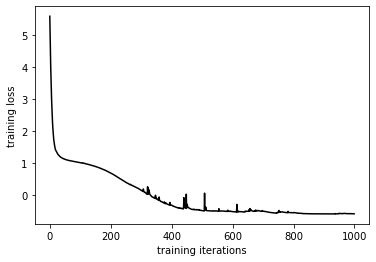

In [8]:
plt.figure()
plt.plot(progress, "k")
plt.xlabel("training iterations")
plt.ylabel("training loss")

Now that we have fit the model, let's see if we have correctly inferred the ground-truth latents up to an arbitrary rotational bias.
To do this, we plot:

(i) ground-truth latents against inferred latents, and \
(ii) the pairwise distance between grounth-truth latents against that of inferred latents.

We know we have inferred the latents correctly when both plots fall on a straight line, with the first plot  wrapping around at the $(0, 2\pi)$ boundaries:

In [9]:
learned_latents = model.lat_dist.prms[0].data.cpu()
true_latents = gen.gs[0]

plearn = (
    model.lat_dist.manif.distance(
        learned_latents.transpose(1, 2), learned_latents.transpose(1, 2)
    )
    .numpy()
    .flatten()
)
ptrue = gen.manifold.manifs[0].distance(true_latents, true_latents).flatten()

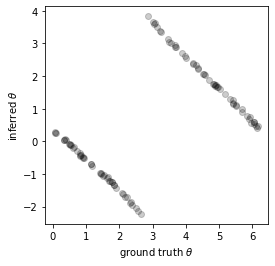

In [10]:
plt.figure(figsize=(4, 4))
plt.plot(true_latents[0], learned_latents[0], "ko", alpha=0.2)
plt.xlabel("ground truth $\\theta$")
plt.ylabel("inferred $\\theta$")
plt.show()

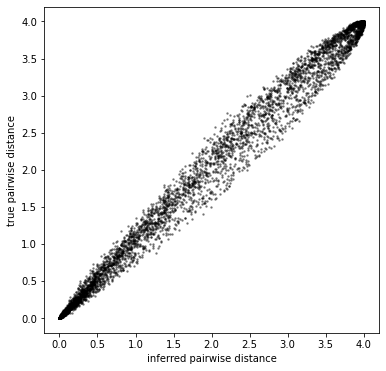

In [11]:
plt.figure(figsize=(6, 6))
plt.plot(plearn, ptrue, "ko", markersize=1.5, alpha=0.2)
plt.xlabel("inferred pairwise distance")
plt.ylabel("true pairwise distance")
plt.show()

In [12]:
def generate_binary_array(n, l):
    if n == 0:
        return l
    else:
        if len(l) == 0:
            return generate_binary_array(n - 1, [np.array([-1]), np.array([1])])
        else:
            return generate_binary_array(
                n - 1,
                (
                    [np.concatenate([i, [-1]]) for i in l]
                    + [np.concatenate([i, [1]]) for i in l]
                ),
            )


def align_torus(x, target):
    target = torch.tensor(target)

    def dist(newmus, params):
        mus = mgp.manifolds.Torus.gmul(newmus, params)
        loss = mgp.manifolds.Torus.distance(mus, target)
        return loss.mean()

    mus = x
    optloss = np.inf

    for coords in generate_binary_array(d, []):
        coords = torch.tensor(coords).reshape(1, d)
        newmus = coords * mus

        for i in range(5):  # random restarts to avoid local minima
            # params = torch.zeros(mod.d)
            params = torch.rand(d) * 2 * np.pi
            params.requires_grad_()
            optimizer = optim.LBFGS([params])

            def closure():
                optimizer.zero_grad()
                loss = dist(newmus, params)
                loss.backward()
                return loss

            optimizer.step(closure)
            loss = closure()
            if loss < optloss:
                optloss = loss
                optcoords = coords
                optparams = params.data.cpu()

    f = lambda x: (mgp.manifolds.Torus.gmul(optcoords * x, optparams) + 2 * np.pi) % (
        2 * np.pi
    )
    return f

In [13]:
align = align_torus(learned_latents, true_latents)

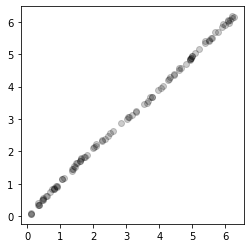

In [14]:
plt.figure(figsize=(4, 4))
plt.plot(align(learned_latents)[0, :, 0], true_latents[0, :, 0], "ko", alpha=0.2)
plt.show()

Let's now plot the inferred tuning curves!

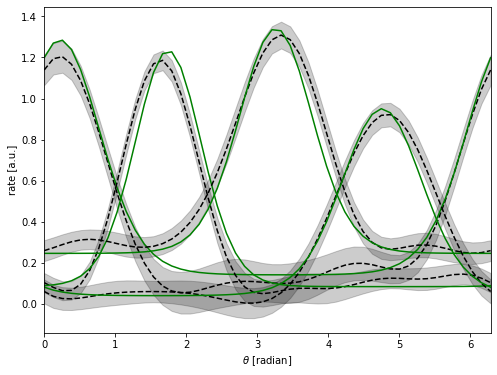

In [15]:
query = torch.tensor(
    np.linspace(0, 2 * np.pi, 50), dtype=torch.get_default_dtype(), device=device
)[None, None, ...]

aligned_query = align(query.cpu())  # align the query for the model
fmean, fvar = model.obs.predict(aligned_query.to(device), full_cov=False)
fstd = fvar.sqrt()
inds = [np.argmin((gen.gprefs[0] - val) ** 2) for val in 0.25 + np.arange(4) * 1.5]
plt.figure(figsize=(8, 6))

for i in inds:
    xs = query.cpu().numpy()
    m, std = [arr.cpu().detach().numpy() for arr in (fmean, fstd)]
    xs = xs[0, 0, :]
    m = m[0, i, :]
    std = std[0, i, :]
    plt.plot(xs, m, "k--")
    plt.fill_between(xs, m - 2 * std, m + 2 * std, color="k", alpha=0.2)
    true_y = gen.gen_data(gs_in=xs[None, ...], sigma=np.zeros((n, 1)))
    plt.plot(xs, true_y[0, i, :], "g-")

plt.xlabel(r"$\theta$ [radian]")
plt.ylabel(r"rate [a.u.]")
plt.xlim(0, 2 * np.pi)
plt.show()